Loan Repayment
========

We'd like to build up an estimate of both who is likely to default on their loan, and for those that do not repay the full amount, how much of the loan they are likely to repay. These will be two separate models that a lending company could use to assess the risk of someone looking for a loan.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3

filename = 'LoanStats3a.csv'

In [130]:
def convert_term(x):
    x = str(x).strip().lower()
    if x == '36 months':
        return 36
    elif x == '60 months':
        return 60
    else:
        return np.NaN

keep = ['annual_inc', 'dti', 'revol_util', 'int_rate', 'loan_amnt', 'term', 'purpose',
        'loan_status', 'total_rec_prncp']

df = pd.read_csv(filename, header=0, usecols=keep)
df = df[keep]
df.int_rate = df.int_rate.map(lambda x: float(str(x).replace('%', '')))
df.revol_util = df.revol_util.map(lambda x: float(str(x).replace('%', '')))
df.term = df.term.map(convert_term)
df.dropna(inplace=True)
df = df[(df.loan_status == 'Fully Paid') | (df.loan_status == 'Charged Off')]

df.head()

,annual_inc,dti,revol_util,int_rate,loan_amnt,term,purpose,loan_status,total_rec_prncp
0,24000.0,27.65,83.7,10.65,5000.0,36.0,credit_card,Fully Paid,5000.00
1,30000.0,1.00,9.4,15.27,2500.0,60.0,car,Charged Off,456.46
2,12252.0,8.72,98.5,15.96,2400.0,36.0,small_business,Fully Paid,2400.00
3,49200.0,20.00,21.0,13.49,10000.0,36.0,other,Fully Paid,10000.00
4,80000.0,17.94,53.9,12.69,3000.0,60.0,other,Fully Paid,3000.00


We have our basic dataframe with the required columns, and the numbers converted. Since we are working with a categorical variable `purpose`, we will use one-hot encoding to build out additional features, and reduce the `loan_status` target to a binary output.

In [131]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [132]:
df.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [133]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
df.loan_status = lb.fit_transform(df.loan_status)
# df.head()
df_new = pd.concat([df, pd.get_dummies(df.purpose)], axis=1)
df_new.drop('purpose', axis=1, inplace=True)
df_new.head()

,annual_inc,dti,revol_util,int_rate,loan_amnt,term,loan_status,total_rec_prncp,car,credit_card,...,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,24000.0,27.65,83.7,10.65,5000.0,36.0,1,5000.00,0,1,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,1.00,9.4,15.27,2500.0,60.0,0,456.46,1,0,...,0,0,0,0,0,0,0,0,0,0
2,12252.0,8.72,98.5,15.96,2400.0,36.0,1,2400.00,0,0,...,0,0,0,0,0,0,0,1,0,0
3,49200.0,20.00,21.0,13.49,10000.0,36.0,1,10000.00,0,0,...,0,0,0,0,0,1,0,0,0,0
4,80000.0,17.94,53.9,12.69,3000.0,60.0,1,3000.00,0,0,...,0,0,0,0,0,1,0,0,0,0


In [134]:
df_new.columns

Index(['annual_inc', 'dti', 'revol_util', 'int_rate', 'loan_amnt', 'term',
       'loan_status', 'total_rec_prncp', 'car', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding'],
      dtype='object')

In [135]:
target_default = df_new.loan_status  # 1 - repay in full
target_repay = df_new.total_rec_prncp / df_new.loan_amnt
df_new.drop(['loan_status', 'total_rec_prncp'], axis=1, inplace=True)
df_new.head()

,annual_inc,dti,revol_util,int_rate,loan_amnt,term,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,24000.0,27.65,83.7,10.65,5000.0,36.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,30000.0,1.00,9.4,15.27,2500.0,60.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12252.0,8.72,98.5,15.96,2400.0,36.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,49200.0,20.00,21.0,13.49,10000.0,36.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,80000.0,17.94,53.9,12.69,3000.0,60.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Model
------

Now that our data is in the right form, we can create our model for loan outcomes based on the features we have selected. Our one-hot encoding allows us to correctly handle the loan purpose field from the original data. We could fit a regression between these features and the default target, but here we'll use some probabilistic programming to get a better idea of our outcomes.

In [173]:
import pymc3 as pm
from pymc3.distributions.continuous import Cauchy
from pymc3.distributions.discrete import Bernoulli

model = pm.Model()
with model:
    p_coef = Cauchy('p', 0, 2.5)
    repaid = Bernoulli('repaid',
                       pm.math.invlogit(df_new.values.T * p_coef),
                       observed=pm.math.invlogit(target_repay.values))
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(df_new.shape[0], step, start, progressbar=True)

/opt/miniconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 358870.967472
         Iterations: 30
         Function evaluations: 38
         Gradient evaluations: 38


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 39736/39736 [3:54:11<00:00,  2.24it/s]   


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee58405400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fee8f161550>]], dtype=object)

/opt/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


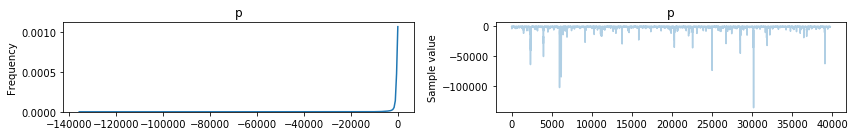

In [183]:
pm.traceplot(trace)